**EVOLUCIÓN TWEETS**

Terminada la escucha en Twitter y recogidos los datos en Mongo, los extraemos para su análisis mediante el uso de la biblioteca 
pandas


In [41]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import bisect 

from datetime import time, timedelta
from pymongo import MongoClient

client = MongoClient('localhost', 27017)

db = client['twitter']

colecciones = db.list_collection_names () #asi obtenemos el listado de colecciones en la bd
print("Total de colecciones:", len(colecciones))

i = 0
lista_cuenta = [] #listado con los counts de todas las colecciones
lista_temas = [] #listado con los temas de las colecciones
lista_df = [] #lista de dataframes

#Recorremos todas las colecciones
while i < len(colecciones):
    coleccion = db[colecciones[i]]
    
    #Recordemos que en 1er documento de la colección colocamos el nombre del tema a propósito
    fila_tema = coleccion.find_one({"tema" : {"$exists": "true"}}, {"_id": 0})
    
    #asi obtenemos el tamaño SIN pasarlo a un dataframe, restamos 1, porque el 1er documento NO cuenta por ser el tema
    lista_cuenta.append(coleccion.estimated_document_count()-1)
    
    #La instruccion anterior devuelve un documento, queremos SOLO el valor de tema
    lista_temas.append(fila_tema["tema"])
    print("Nombre coleccion:", colecciones[i], ", Tema:", lista_temas[i], ", Tamaño:", lista_cuenta[i])
    
    #cargamos el dataframe por cada tema, quitamos SIEMPRE la primera fila, qué es donde está el tema
    df = pd.DataFrame(list(coleccion.find({"tema" : {"$exists": "false"}})))
    lista_df.append(df)                       
    i += 1

print("Total de dataframes cargados:", len(lista_df))

#Fusionamos las dos listas en un diccionario

dicctemascuenta = dict(zip(lista_temas, lista_cuenta))

#Ordenamos el diccionario segun numero de tweets de mayor a menor

dicctemascuentaOr = sorted(dicctemascuenta.items(), key=operator.itemgetter(1), reverse=True)

#Convertirmos el diccionario en un DataFrame

dfFinal = pd.DataFrame.from_dict(dicctemascuentaOr).rename(columns={0:'Tema', 1:'Nº de Tweets'})

dfFinal.head(10)

Total de colecciones: 10
Nombre coleccion: tt4 , Tema: #BuenosDías , Tamaño: 106
Nombre coleccion: tt5 , Tema: #LaCafeteraSalvarLaSalud , Tamaño: 8
Nombre coleccion: gt4 , Tema: ley celaa , Tamaño: 58
Nombre coleccion: gt3 , Tema: elecciones eeuu , Tamaño: 70
Nombre coleccion: gt1 , Tema: elecciones estados unidos 2020 , Tamaño: 3
Nombre coleccion: gt2 , Tema: elecciones estados unidos , Tamaño: 34
Nombre coleccion: tt1 , Tema: #FelizJueves , Tamaño: 1382
Nombre coleccion: tt3 , Tema: Maradona , Tamaño: 50273
Nombre coleccion: gt5 , Tema: sean connery , Tamaño: 12
Nombre coleccion: tt2 , Tema: #OndaCeroCumple30 , Tamaño: 71
Total de dataframes cargados: 10


,Tema,Nº de Tweets
0,Maradona,50273
1,#FelizJueves,1382
2,#BuenosDías,106
3,#OndaCeroCumple30,71
4,elecciones eeuu,70
5,ley celaa,58
6,elecciones estados unidos,34
7,sean connery,12
8,#LaCafeteraSalvarLaSalud,8
9,elecciones estados unidos 2020,3


**Gráfico de barras**

En la tabla de arriba podemos ver la cantidad de tweets de diferentes temas destacados. Veamos esos datos representados mediante 
gráficas:

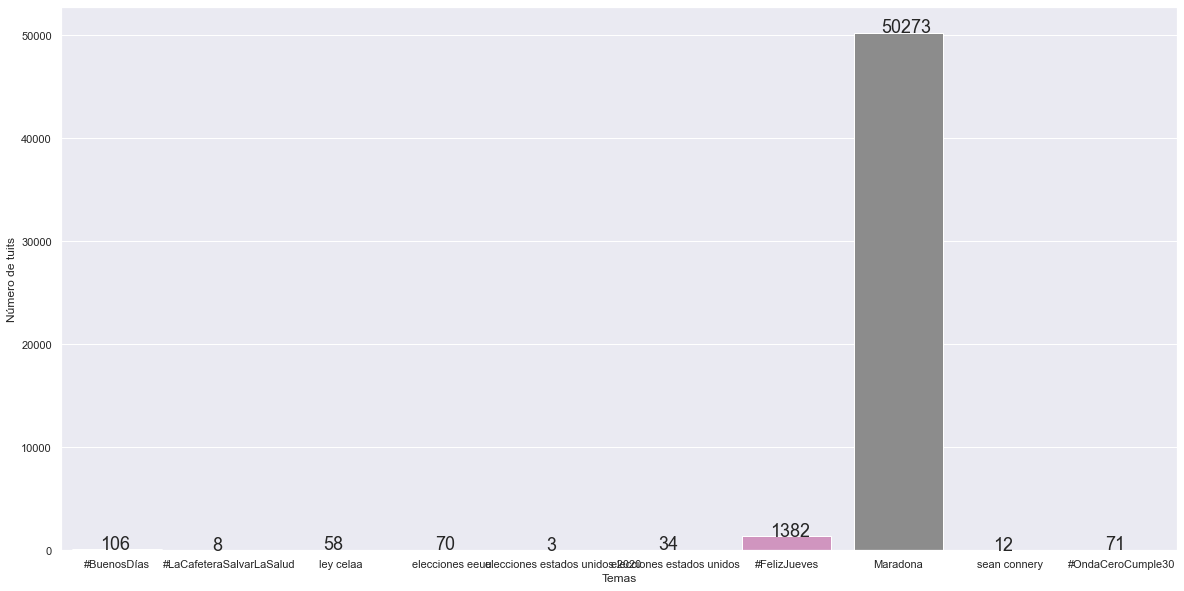

In [34]:
sns.set(rc={'figure.figsize':(20,10)})
plt = sns.barplot(x = lista_temas, y = lista_cuenta)
plt.set(xlabel = "Temas", ylabel = "Número de tuits")

for index,data in enumerate(lista_cuenta):
    plt.text(x=index-0.15 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=18))

Los temas 'Maradona' y '#FelizJueves' tienen resultados tan altos que eclipsan al resto de temas. Veamos una nueva gráfica 
prescindiendo de esos dos outliers:

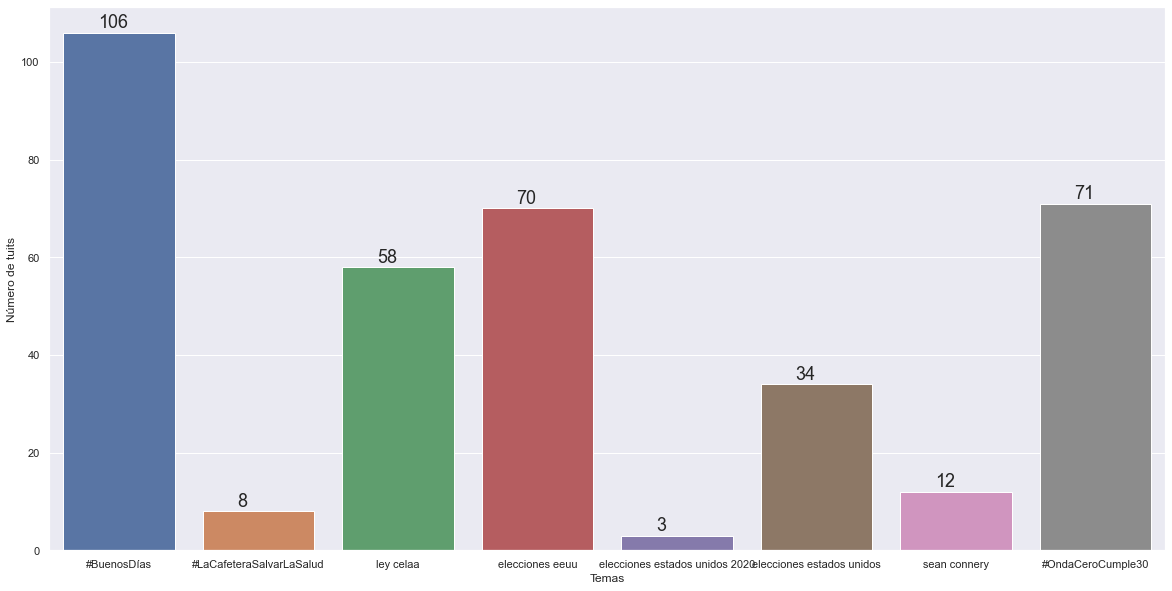

In [35]:
lista_cuenta.pop(6)
lista_cuenta.pop(6)
lista_temas.pop(6)
lista_temas.pop(6)

sns.set(rc={'figure.figsize':(20,10)})
plt = sns.barplot(x = lista_temas, y = lista_cuenta)
plt.set(xlabel = "Temas", ylabel = "Número de tuits")

for index,data in enumerate(lista_cuenta):
    plt.text(x=index-0.15 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=18))

**Gráfica tarta**

Otra forma interesante de visualizar los datos es mediante gráficas de tarta. Podemos comparar la cantidad de tweets por temas entre sí, teniendo en cuenta si son temas de Google Trends o del Trending Topic de Twitter:

Proporción tweets de los 5 términos de búsqueda destacados en Google Trends: 


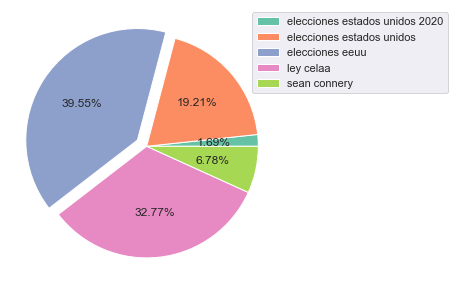

Proporción tweets de los 5 términos de búsqueda destacados en Trending Topics: 


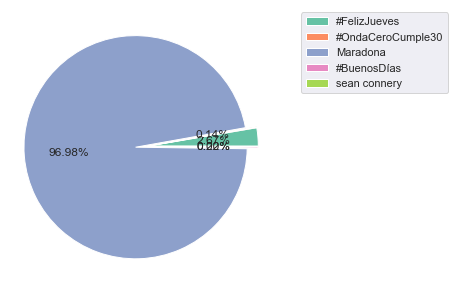

In [53]:
print("Proporción tweets de los 5 términos de búsqueda destacados en Google Trends: ")

i = 1
contador = []
while i <= 5:
    tema = "gt" + str(i) # tema indica en qué colección buscar
    contador.append(db[tema].estimated_document_count()-1) #saca el total de tweets por colección
    i += 1
    
g_temas = {1 : "elecciones estados unidos 2020", 2: "elecciones estados unidos", 3: "elecciones eeuu", 4: "ley celaa", 5: "sean connery"}
g_labels = list(g_temas.values())
g_trends = []

plt.figure(figsize=(5, 8))
plt.pie(x=contador, radius = 1, colors = sns.color_palette("Set2"), startangle = 0, autopct = "%1.2f%%", explode = (0,0,0.1,0,0))
plt.legend(loc="upper right", bbox_to_anchor=(1.60, 1), labels = g_labels)
plt.show()

print("Proporción tweets de los 5 términos de búsqueda destacados en Trending Topics: ")

i = 1
contador = []
while i <= 5:
    tema = "tt" + str(i) # tema indica en qué colección buscar
    contador.append(db[tema].estimated_document_count()-1) #saca el total de tweets por colección
    i += 1

t_temas = {1 : "#FelizJueves", 2: "#OndaCeroCumple30", 3: "Maradona", 4: "#BuenosDías", 5: "sean connery"}
t_labels = list(t_temas.values())
t_trends = []

plt.figure(figsize=(5, 8))
plt.pie(x=contador, radius = 1, colors = sns.color_palette("Set2"), startangle = 0, autopct = "%1.2f%%", explode = (0,0,0.1,0,0))
plt.legend(loc="upper right", bbox_to_anchor=(1.60, 1), labels = t_labels)
plt.show()

Claramente el tema 'Maradona' es lo más destacado de Twitter

**Gráfica linea**

Lo último es obtener una gráfica que permita hacer comparaciones en una escala temporal. Vamos a graficar cómo evoluciona el número de tweets a medida que pasa el tiempo. Se puede escoger entre 2 y 5 temas para comparar y el tramo de tiempo que se quiere graficar

Supongamos que queremos graficar la evolución de tweets de solo los temas de Google Trends recopilados, entre los 10 y los 30 minutos de escucha, entonces:

Indica cuántos temas quieres comparar (mín 2, max 5): 5
Indica escala temporal: 
Primer minuto (0-39): 10
Último minuto (1-40): 30

Temas destacados Google Trends:             Temas destacados Trending Topics:
gt1 <- elecciones estados unidos 2020       tt1 <- #FelizJueves  
gt2 <- elecciones estados unidos            tt2 <- #OndaCeroCumple30
gt3 <- elecciones eeuu                      tt3 <- Maradona
gt4 <- ley celaa                            tt4 <- #Buenos días
gt5 <- sean connery                         tt5 <- sean connery

Escribe uno de los temas que quieras comparar (ej: gt1): gt1
Escribe uno de los temas que quieras comparar (ej: gt1): gt2
Escribe uno de los temas que quieras comparar (ej: gt1): gt3
Escribe uno de los temas que quieras comparar (ej: gt1): gt4
Escribe uno de los temas que quieras comparar (ej: gt1): gt5


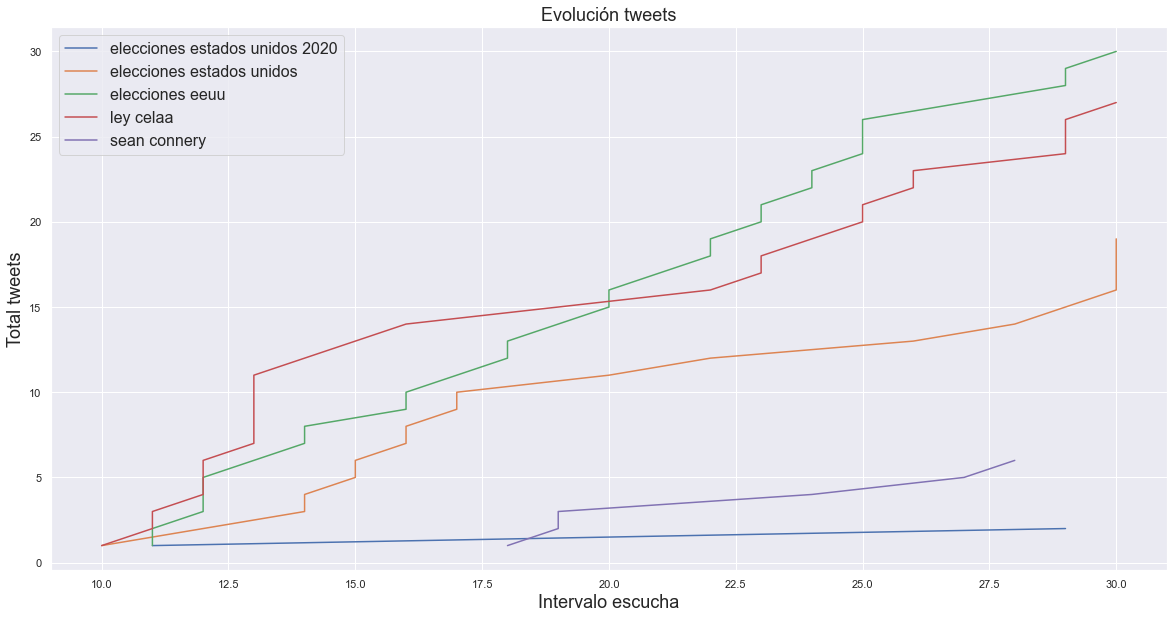

In [58]:
"""Evolución tweets en 40 minutos. Para ello transformaremos los datos de la columna 'created_at', que recoge la fecha y hora."""
#Para realizar comparaciones se tienen que transformar datos de cada una de las colecciones comparadas, entonces recurrimos
#al uso de funciones para automatizar el proceso:

#Comandos usuario:
cantidad = int(input("Indica cuántos temas quieres comparar (mín 2, max 5): "))
print("Indica escala temporal: ")
inicio = int(input("Primer minuto (0-39): "))
final = int(input("Último minuto (1-40): "))
print("""
Temas destacados Google Trends:             Temas destacados Trending Topics:
gt1 <- elecciones estados unidos 2020       tt1 <- #FelizJueves  
gt2 <- elecciones estados unidos            tt2 <- #OndaCeroCumple30
gt3 <- elecciones eeuu                      tt3 <- Maradona
gt4 <- ley celaa                            tt4 <- #Buenos días
gt5 <- sean connery                         tt5 <- sean connery
""")
temas = ["", "", "", "", ""]
for i in range(cantidad):
    tema = input("Escribe uno de los temas que quieras comparar (ej: gt1): ")
    temas[i] = tema
    
    
#esta función extrae los valores para el eje x, la escala temporal 
def evol_x(coleccion): 
    df_ev = pd.DataFrame(list(db[coleccion].find({}))) #extrae la coleccion de la bd

    df_ev = df_ev.dropna(subset = ["created_at"]) #eliminar fila sin valor

    df_ev["hora_creacion"] = df_ev["created_at"].str[11:19] #añadimos nueva columna que indica 'hora' creación tweet
    
    hora = df_ev['hora_creacion'].iloc[0] #extraer 'hora' inicio escucha
    hora = int(hora[1])
    minuto = df_ev['hora_creacion'].iloc[0] #extraer 'minuto' inicio escucha
    minuto = int(minuto[3:5])

    df_ev["hora_creacion"] = pd.to_datetime(df_ev["hora_creacion"]) #lo pasamos a formato tiempo para hacer cálculos

    #Escala tiempo de 0 a 40 minutos:    
    #restamos hora inicio escucha para obtener una escala temporal
    df_ev["min"] = ((df_ev["hora_creacion"] - pd.Timedelta(hora, unit='h') - pd.Timedelta(minuto, unit='m'))) 
    df_ev["min"] = df_ev["min"].astype(str) #pasamos los nuevos datos a str para extraer solo los minutos
    df_ev["min"] = df_ev["min"].str[14:16] #nos quedamos solo con los minutos
    minutos_x = list(df_ev["min"])
    return minutos_x
    
#esta función extrae los valores para el eje y, el incremento de tweets acumulativo  
def evol_y(coleccion):
    #sacamos el total de tweets
    df_ev = pd.DataFrame(list(db[coleccion].find({}))) #extrae la coleccion de la bd
    df_ev = df_ev.dropna(subset = ["created_at"]) #eliminar fila sin valor
    df_ev["contar"] = df_ev.index #recurrimos a un indice para hacer la cuenta acumulativa
    contador_y = list(df_ev["contar"]) #pasamos los datos a una lista
    return contador_y
    
#función que recoge el proceso de comparación una vez se han obtenido los datos que necesitamos 
#por defecto compara mínimo dos colecciones
def comparador_evol(coleccion1, coleccion2, coleccion3="", coleccion4="", coleccion5=""): #compara hasta 5 colecciones
    
    #reúne y transforma los valores del eje x 
    def valores_eje_x(coleccion): #en el parametros indicamos en qué colección extraer los datos
        x = []
        xx = evol_x(coleccion) #sacamos los minutos en los que se publican tweets
        for i in xx:            #los convertimos a int para representarlos en la gráfica
            x.append(int(i))
        escala_personalizada = []
        for n in x:
            if n >= inicio and n <= final:
                escala_personalizada.append(n)
        x = escala_personalizada
        return x 
    
    #reúne y transforma los valores del eje x
    def valores_eje_y(x, coleccion):
        y = evol_y(coleccion) #sacamos la cantidad de tweets
        principio = int(bisect.bisect_left(x, inicio)) #buscar en x cuando se alcanza el minuto de inicio fijado en la búsqueda
        hasta = int(len(x))
        final = principio + hasta
        nuevo_y = y[principio:final]
        y = nuevo_y
        return y
    
    #graficar la coleccion, creamos una función que reflejará la evolución de las distintas colecciones
    def graficar(x, y, coleccion):
        #creamos un df para establecer etiquetas según qué colección
        df_label = pd.DataFrame(list(db[coleccion].find({"tema" : {"$exists": "false"}})))
        label = str(df_label['tema'].iloc[0])
        #ahora que ya tenemos los valores del eje (x, y) y además tenemos la etiqueta podemos añadir el método plot
        plt.plot(x, y, label = label) 
    
    #función para ejecutar la búsqueda de datos
    def ejecuta(coleccion):
        graficar(valores_eje_x(coleccion), valores_eje_y(valores_eje_x(coleccion), coleccion), coleccion)
        
    ejecuta(coleccion1) 

    ejecuta(coleccion2)
    
    
    #graficar la tercera coleccion 
    if coleccion3 != "":
        ejecuta(coleccion3)
        
    #graficar la cuarta coleccion 
    if coleccion4 != "":
        ejecuta(coleccion4)
    
    #graficar la quinta coleccion 
    if coleccion5 != "":
        ejecuta(coleccion5)
  
    #nombrar los ejes: 
    plt.xlabel('Intervalo escucha', fontsize=18) 
    plt.ylabel('Total tweets', fontsize=18)
    
    params = {'legend.fontsize': 16, 'legend.handlelength': 2} #ajustar tamaño leyenda
    plt.rcParams.update(params)
    
    #titulo gráfica
    plt.title('Evolución tweets', fontsize=18) 
  
    #leyenda 
    plt.legend() 
  
    #mostrar gráfica 
    plt.show() 
    


#ejecutamos la funcion con los temas escogidos por el usuario
comparador_evol(temas[0], temas[1], temas[2], temas[3], temas[4])

